In [4]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff7 as ds
from copy import copy as dup
from scipy.integrate import solve_ivp #odeint is deprecated

#for 3d plots
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D

import numba as nb

This notebook is for end-to-end testing of diffusion in 2D. It sets up a non-equilibrium liqiud surface and performs diffusion integrating with two methods

In [5]:
%matplotlib widget

(500, 500)
[-10.          -9.95991984  -9.91983968  -9.87975952  -9.83967936
  -9.7995992   -9.75951904  -9.71943888  -9.67935872  -9.63927856]
[-20. -20. -20. -20. -20. -20. -20. -20. -20. -20.]
[-10. -10. -10. -10. -10. -10. -10. -10. -10. -10.]
[-20.         -19.91983968 -19.83967936 -19.75951904 -19.67935872
 -19.5991984  -19.51903808 -19.43887776 -19.35871743 -19.27855711]


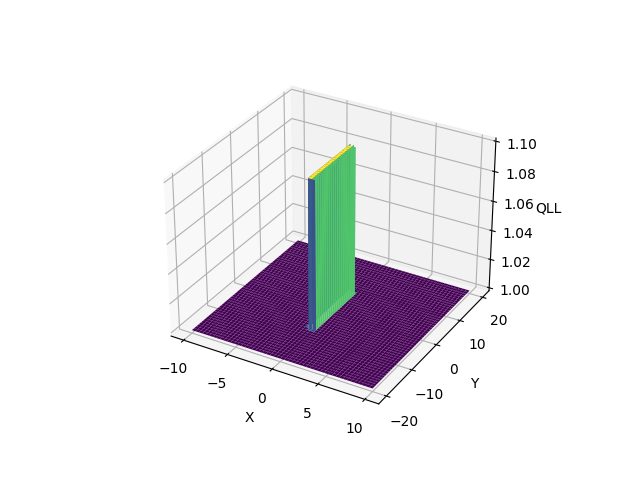

In [6]:
nx = nb.types.int64(500)
ny = nb.types.int64(500)

xmax=10
ymax=20
deltaX= 2*xmax/nx


xmid = int(nx/2)
ymid = int(ny/2)

mesh = np.meshgrid(np.linspace(-xmax,xmax,nx),np.linspace(-ymax,ymax,ny))
X = mesh[0].T
Y = mesh[1].T
print(np.shape(X))
print(X[0:10,0])
print(Y[0:10,0])

print(X[0,0:10])
print(Y[0,0:10])

#Fliq = np.ones(np.shape(X)) - 0.001*(X**2 + Y**2) 
Fliq = np.ones(np.shape(X)) 
Fliq[xmid-10:xmid+10,ymid-100:ymid+100] = 1.1

""" plt.figure()

ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,X,cmap='viridis')
#ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('X')
plt.show()

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Y,cmap='viridis')
#ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Y')
plt.show() """

plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X,Y,Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

In [ ]:
#calculate diffusion differential equation DIY euler method
# Diffusion coefficient
D = 0.02e-2 # micrometers^2/microsecond

# Diffusion coefficient scaled for this time-step and space-step
DoverdeltaX2 = D/deltaX**2

counter = 10000

dt = 100.0 # microseconds
tmax = counter*dt
 
Fliq_next = np.copy(Fliq)

for i in range(counter):
    Fliq_next = Fliq_next + np.reshape( 
                            ds.diffuse_2d(0.0,
                                        np.reshape(np.ascontiguousarray(Fliq_next),nx*ny),#Fliq_next,
                                        D,
                                        np.array(list(map(nb.types.int64,[*np.shape(Fliq)]))))*dt,
                                        np.shape(Fliq))

In [ ]:
#try solving with solve_ivp instead #NOTE: not wokring right 

ylast = dup(Fliq)

shape = np.array((nx,ny))

# Time steps
t0 = 0.0
tinterval = [t0, tmax]

# Call the ODE solver
layer = 0

# Integrate up to next time step
ode_solution_dict = solve_ivp(ds.diffuse_2d, tinterval, np.reshape(ylast,nx*ny), args=(D,shape))

In [ ]:
#inspect solution
print(ode_solution_dict.keys())
Fliq_sol = ode_solution_dict['y']
print(np.shape(Fliq_sol))

Fliq_sol_repacked = np.array(list(map((lambda x: np.reshape(x,shape)),Fliq_sol.T)))
print(np.shape(Fliq_sol_repacked))

print(np.shape(ode_solution_dict['t']))

In [ ]:
Fliq_next = np.reshape(Fliq_sol_repacked[-1],(nx,ny)) #last element of 'y' is the final state

In [ ]:
#plot the original minus the calculated diffusive effects
plt.figure()
ax = plt.axes(projection='3d')


#ax.plot_surface(X,Y,Fliq_next,cmap='viridis')
ax.plot_surface(X,Y,Fliq_next-Fliq,cmap='viridis')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

In [ ]:
#slice through the middle of the liquid before diffusion in X

# print(X[:,int(ny/2)])

plt.figure()
ax = plt.axes()
ax.plot(X[:,int(ny/2)],Fliq[:,int(ny/2)])
ax.plot(X[:,int(ny/2)],Fliq_next[:,int(ny/2)])
ax.set_xlabel('X')
ax.set_ylabel('QLL')
plt.show()

print(np.trapz(Fliq[:,int(ny/2)],X[:,int(ny/2)],))
print(np.trapz(Fliq_next[:,int(ny/2)],X[:,int(ny/2)],))


In [ ]:
#slice through the middle of the liquid before diffusion in Y


plt.figure()
ax = plt.axes()
ax.plot(Y[xmid,:],Fliq[xmid,:])
ax.plot(Y[xmid,:],Fliq_next[xmid,:])
ax.set_xlabel('Y')
ax.set_ylabel('QLL')
plt.show()


print(np.trapz(Fliq[xmid,:],Y[xmid,:]))
print(np.trapz(Fliq_next[xmid,:],Y[xmid,:]))


In [ ]:
#plot the results
plt.figure()
ax = plt.axes(projection='3d')

ax.plot_surface(X,Y,Fliq_next,cmap='viridis')


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('QLL')
plt.show()

In [ ]:
from matplotlib import animation
from IPython.display import HTML
from datetime import date

In [ ]:
#File management parameters
#Qualifier tag for file names #should include what makes this figure unique
tag = "" ### NOTE: if you do not change the tag between runs on the same day you will overwrite the previous run: try to use a descriptive tag
todays_date = date.today().strftime("%d-%m-%Y")

#File writer for saving animations as gifs
writergif = animation.PillowWriter(fps=480) 

#optional for saving as mp4, (or anim or mpg) but requires ffmpeg

writervideo = animation.FFMpegWriter(fps=60) #make sure files end in .mp4 oetc.

In [ ]:
# animation of facet depth over time #TODO: inc
Fliqanim = Fliq_sol_repacked
tanim = ode_solution_dict['t']

# initialize figure
myFig = plt.figure()
ax = plt.subplot()

# define function to draw each frame
def makeFrame(n):
    pass

# generate animation
anim = animation.FuncAnimation(fig = myFig,func = makeFrame,frames = len(tanim))

anim.save(todays_date+"_2D_"+tag+"_diffusion.gif", writer=writergif)

HTML(anim.to_jshtml())